After testing the effectiveness of using the MODIS product to classify fires from the GFA dataset, this notebook uses MODIS to classify fires in the MTBS and GFD datasets, which do not originally contain a land cover attribute.

In [1]:
import sys
import os
import re
import pickle

sys.path.append("..")
from utils.landcover_segmentation import *
from utils import wildfire_powerlaw as wfpl

modis_folder = "/Users/lukevonkapff/wildfires/MODIS_USA/GeoTIFF"
modis_files = [os.path.join(modis_folder, f) for f in os.listdir(modis_folder) if f.endswith(".tif")]
modis_by_year = {}
for f in modis_files:
    match = re.search(r"A(\d{4})", os.path.basename(f))
    if match:
        year = int(match.group(1))
        modis_by_year.setdefault(year, []).append(f)

modis_to_gfa = {
    0: "Water",
    1: "Evergreen Needleleaf forest",
    2: "Evergreen Broadleaf forest",
    3: "Deciduous Needleleaf forest",
    4: "Deciduous Broadleaf forest",
    5: "Mixed forest",
    6: "Closed shrublands",
    7: "Open shrublands",
    8: "Woody savannas",
    9: "Savannas",
    10: "Grasslands",
    11: "Permanent wetlands",
    12: "Croplands",
    13: "Urban and built-up",
    14: "Cropland/Natural vegetation mosaic",
    15: "Snow and ice",
    16: "Barren or sparsely vegetated"
}

### Classify MTBS

In [2]:
# REPLACE WITH PATH TO MTBS DOWNLOADED DATA
mtbs_gdf = load_shapefile(
    "/Users/lukevonkapff/wildfires/MTBS/S_USA.MTBS_BURN_AREA_BOUNDARY.shp",
    "EPSG:4269",
    area_col="AREA_SQKM"
)

mtbs_filtered = mtbs_gdf[mtbs_gdf["AREA_SQKM"] >= 4].copy()
mtbs_filtered = mtbs_filtered.rename(columns={
    "YEAR": "year",
    "AREA_SQKM": "area_km2"
})

mtbs_classified = classify_with_modis(
    mtbs_filtered,
    "year",    
    modis_by_year,
    modis_to_gfa
)

print(f"Classified {len(mtbs_classified)} MTBS fires over 4 km²")
mtbs_classified[["year", "area_km2", "modis_class"]].head()

Classified 25256 MTBS fires over 4 km²


,year,area_km2,modis_class
0,2024,4.994606,Unknown
1,2024,10.170520,Unknown
2,2024,8.490276,Unknown
3,2023,16.290980,Unknown
4,2024,6.573028,Unknown


### Classify Idaho GFD

In [3]:
# REPLACE WITH PATH TO GDF DOWNLOADED DATA
idaho_gdf = gpd.read_file("/Users/lukevonkapff/wildfires/ID_HFDB/HFD_HistoricFiresDatabase7_0.gdb", layer="Fires1950_Present")
idaho_gdf = idaho_gdf.to_crs("EPSG:6933")
idaho_gdf["area_km2"] = idaho_gdf.geometry.area / 1e6

idaho_filtered = idaho_gdf[idaho_gdf["area_km2"] >= 4].copy()
idaho_filtered = idaho_filtered.rename(columns={"FIRE_YEAR": "year"})

idaho_classified = classify_with_modis(idaho_filtered, "year", modis_by_year, modis_to_gfa)

These take a long time to run, so saving them below so you can call them in later.

In [5]:
mtbs_path = "../data/mtbs_2003_2016_classified_timevarying.shp"
mtbs_classified.to_file(mtbs_path)
print(f"Saved GeoDataFrame to {mtbs_path}")

idaho_path = "../data/idaho_2003_2016_classified_timevarying.shp"
idaho_classified.to_file(idaho_path)
print(f"Saved GeoDataFrame to {idaho_path}")

gfa_shp = "../data/gfa_2003_2016_usa_classified_timevarying.shp"
gfa_classified = gpd.read_file(gfa_shp)

Saved GeoDataFrame to ../data/mtbs_2003_2016_classified_timevarying.shp
Saved GeoDataFrame to ../data/idaho_2003_2016_classified_timevarying.shp


Now, the following code runs the distribution fitting routine on each land cover type for each dataset.

In [6]:
results_gfa = {}

for modis_cat, subset in gfa_classified[(gfa_classified["year"] >= 2003) & (gfa_classified["year"] <= 2016)].groupby("modis_clas"):
    data = subset["area_km2"].values
    
    if len(data) == 0:
        continue
    
    print(f"\n=== {modis_cat} (n={len(data)}) ===")
    
    params = wfpl.summarize_parameters_bootstrap(
        data, R=50, xmin=4, random_state=42
    )
    R, best = wfpl.likelihood_matrix_and_best(
        data, xmin=4
    )
    
    results_gfa[modis_cat] = {
        "params": params,
        "likelihood_matrix": R,
        "best_fit": best
    }

results_idaho = {}

for modis_cat, subset in idaho_classified[(idaho_classified["year"] >= 2003) & (idaho_classified["year"] <= 2016)].groupby("modis_class"):
    data = subset["area_km2"].values
    
    if len(data) == 0:
        continue
    
    print(f"\n=== {modis_cat} (n={len(data)}) ===")
    
    params = wfpl.summarize_parameters_bootstrap(
        data, R=50, xmin=4, random_state=42
    )
    R, best = wfpl.likelihood_matrix_and_best(
        data, xmin=4
    )
    
    results_idaho[modis_cat] = {
        "params": params,
        "likelihood_matrix": R,
        "best_fit": best
    }

results_mtbs = {}

for modis_cat, subset in mtbs_classified[(mtbs_classified["year"] >= 2003) & (mtbs_classified["year"] <= 2016)].groupby("modis_class"):
    data = subset["area_km2"].values
    
    if len(data) == 0:
        continue
    
    print(f"\n=== {modis_cat} (n={len(data)}) ===")
    
    params = wfpl.summarize_parameters_bootstrap(
        data, R=50, xmin=4, random_state=42
    )
    R, best = wfpl.likelihood_matrix_and_best(
        data, xmin=4
    )
    
    results_mtbs[modis_cat] = {
        "params": params,
        "likelihood_matrix": R,
        "best_fit": best
    }

save_path_gfa = "../data/gfa_static_fits_by_biome_2003_2016.pkl"
with open(save_path_gfa, "wb") as f:
    pickle.dump(results_gfa, f)

print(f"Saved overall_results to: {save_path_gfa}")

save_path_mtbs = "../data/mtbs_static_fits_by_biome_2003_2016.pkl"
with open(save_path_mtbs, "wb") as f:
    pickle.dump(results_mtbs, f)

print(f"Saved overall_results to: {save_path_mtbs}")

save_path_id = "../data/idaho_static_fits_by_biome_2003_2016.pkl"
with open(save_path_id, "wb") as f:
    pickle.dump(results_idaho, f)

print(f"Saved overall_results to: {save_path_id}")



=== Barren or sparsely vegetated (n=35) ===
there are 35 points above xmin 4.0 km^2

=== Closed shrublands (n=147) ===
there are 147 points above xmin 4.0 km^2

=== Croplands (n=6451) ===
there are 6451 points above xmin 4.0 km^2

=== Deciduous Broadleaf forest (n=598) ===
there are 598 points above xmin 4.0 km^2

=== Evergreen Broadleaf forest (n=427) ===
there are 427 points above xmin 4.0 km^2

=== Evergreen Needleleaf forest (n=557) ===
there are 557 points above xmin 4.0 km^2

=== Grasslands (n=6147) ===
there are 6147 points above xmin 4.0 km^2

=== Mixed forest (n=199) ===
there are 199 points above xmin 4.0 km^2

=== Open shrublands (n=480) ===
there are 480 points above xmin 4.0 km^2

=== Other (n=57) ===
there are 57 points above xmin 4.0 km^2

=== Savannas (n=2229) ===
there are 2229 points above xmin 4.0 km^2

=== Urban and built-up (n=12) ===
there are 12 points above xmin 4.0 km^2

=== Woody savannas (n=2500) ===
there are 2500 points above xmin 4.0 km^2

=== Barren or s

The following table summarizes the "good" fits for each dataset+land cover type. Good fits are ones fit on >400 fires, loglikelihood relative to the best fit is <=2.0, and they do not reduce to a simpler distribution with 95% confidence. This includes an additional filter to remove fits where the relative error on a parameter was too big, but that max_rel_error constraint was not used in future analysis.

In [7]:
results_dicts = {
    "GFA": results_gfa,
    "Idaho": results_idaho,
    "MTBS": results_mtbs
}

counts_dicts = {
    "GFA": gfa_classified[(gfa_classified["year"].between(2003,2016)) & (gfa_classified["area_km2"]>=4)]["modis_clas"].value_counts(),
    "Idaho": idaho_classified[(idaho_classified["year"].between(2003,2016)) & (idaho_classified["area_km2"]>=4)]["modis_class"].value_counts(),
    "MTBS": mtbs_classified[(mtbs_classified["year"].between(2003,2016)) & (mtbs_classified["area_km2"]>=4)]["modis_class"].value_counts(),
}

build_comparison_table(results_dicts, counts_dicts, max_relerr = 1)

,modis_class,MTBS_n,MTBS_fit,MTBS_loglik,MTBS_reduces_to,GFA_n,GFA_fit,GFA_loglik,GFA_reduces_to,Idaho_n,Idaho_fit,Idaho_loglik,Idaho_reduces_to
0,Croplands,,,,,6451,lognormal,,,,,,
1,,,,,,,stretched_exponential,0.398,,,,,
2,,,,,,,weibull,0.398,,,,,
3,,,,,,,generalized_pareto,1.795,,,,,
4,Deciduous Broadleaf forest,754,generalized_pareto,,,598,generalized_pareto,,,,,,
5,,,lognormal,0.61,,,,,,,,,
6,Evergreen Broadleaf forest,726,generalized_pareto,,,427,generalized_pareto,,,,,,
7,Evergreen Needleleaf forest,582,truncated_power_law,,,557,truncated_power_law,,,,,,
8,Grasslands,4009,lognormal,,,6147,lognormal,0.996,,2791,weibull,0.0,
9,Mixed forest,562,generalized_pareto,,,,,,,,,,


The following function visualizes the "good" fits in parameter space for a all datasets and land cover types.

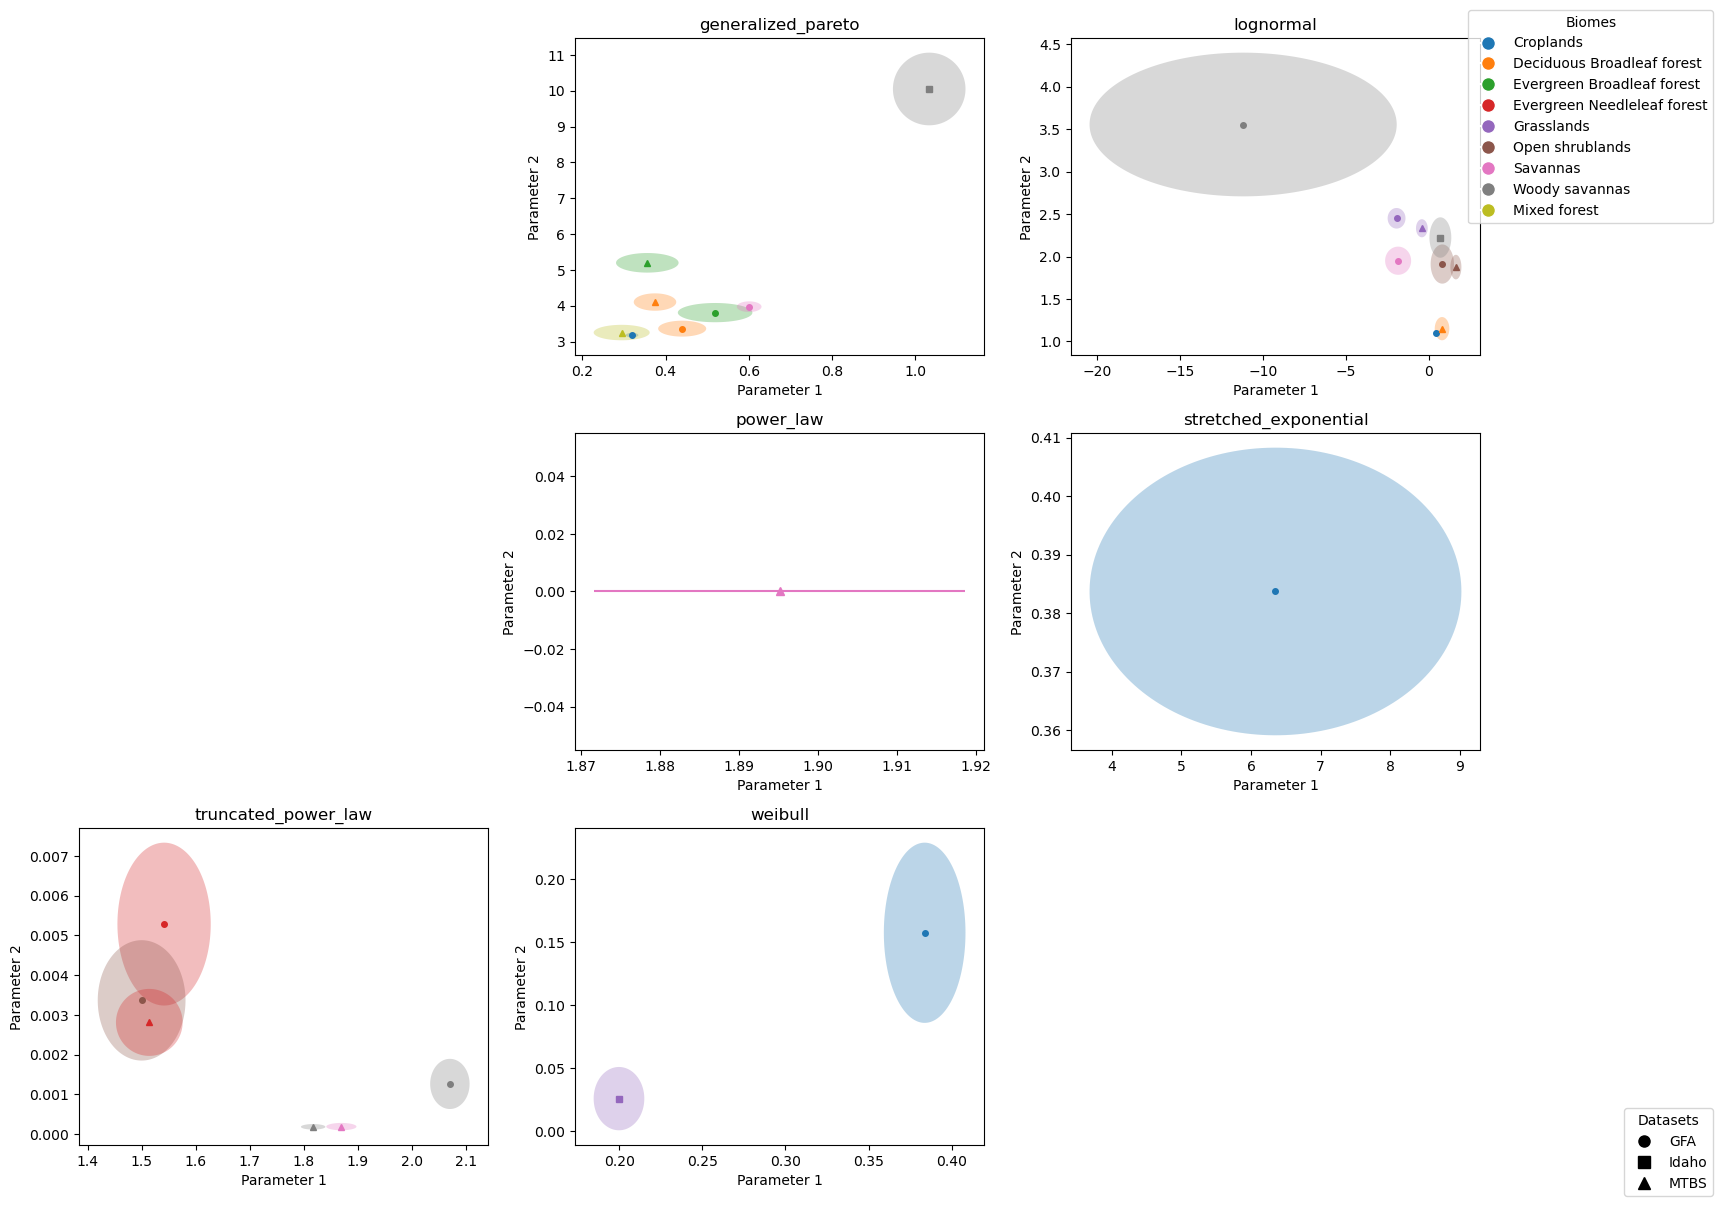

In [8]:
plot_distribution_params(results_dicts, counts_dicts, min_count=400, llhr_cutoff=2, log_axes=False, max_rel_error=1)

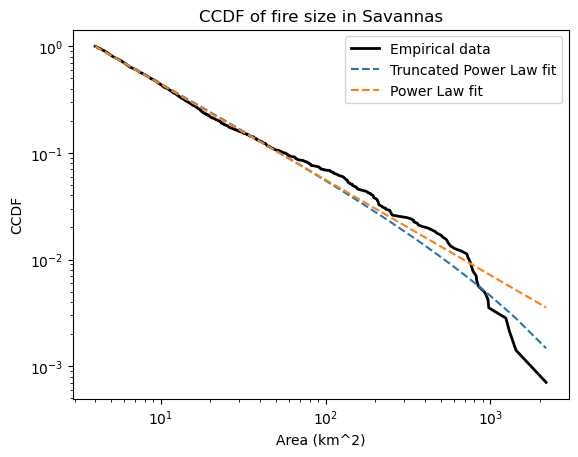

<Axes: title={'center': 'CCDF of fire size in Savannas'}, xlabel='Area (km^2)', ylabel='CCDF'>

In [9]:
plot_modis_category_ccdf(mtbs_classified, "Savannas", xmin=4, which=["truncated_power_law", "power_law"])